In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import keras

2024-06-15 17:51:35.841686: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 17:51:35.875523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 17:51:36.445429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.__version__, keras.__version__

('2.16.1', '3.3.3')

In [4]:
# This is required to download Gemma model
# import kagglehub
# kagglehub.login()

# Build model

In [5]:
from keras_llm_light.models import gemma

LORA_RANK = 4
LORA_APLHA = 32.0
MAX_SEQ_LENGTH = 1024

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

trainer, llm = gemma.build_gemma_llm(
    lora_rank=LORA_RANK,
    lora_alpha=LORA_APLHA,
    max_sequence_len=MAX_SEQ_LENGTH,
    optimizer=optimizer,
)

2024-06-15 17:51:44.380697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 17:51:44.407744: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 17:51:44.407889: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Building Gemma 2B model on CPU ...


normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

2024-06-15 17:51:55.973107: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Single block trainable weights:
- decoder_block/attention/query/lora_A/kernel [2048, 4]
- decoder_block/attention/query/lora_B/kernel [8, 4, 256]
- decoder_block/attention/value/lora_A/kernel [2048, 4]
- decoder_block/attention/value/lora_B/kernel [1, 4, 256]


Preparing/Quantizing weights: 100%|██████████| 18/18 [00:32<00:00,  1.83s/it]


                                        Block Memory Usage (Num blocks 18)                                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃                                                 ┃             ┃         ┃   Mem Usage ┃    FP32 Mem ┃           ┃
┃                                          Tensor ┃       Shape ┃   dtype ┃        [MB] ┃  Usage [MB] ┃ Trainable ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│          decoder_block/pre_attention_norm/scale │      [2048] │ float16 │       0.004 │       0.008 │     False │
│            decoder_block/attention/query/kernel │   [8, 2048, │ float16 │       8.000 │      16.000 │     False │
│                                                 │        256] │         │             │             │           │
│              decoder_block/attention/key/kernel │   [1, 2048, │ float16 │       1.000 │       2.000 │     False │
│                                                 │        256] │         │             │             │           │
│            decoder_block/attention/value/kernel │   [1, 2048, │ float16 │       1.000 │       2.000 │     False │
│                                                 │        256] │         │             │             │           │
│ decoder_block/attention/attention_output/kernel │    [8, 256, │ float16 │       8.000 │      16.000 │     False │
│                                                 │       2048] │         │             │             │           │
│     decoder_block/attention/query/lora_A/kernel │   [2048, 4] │ float32 │       0.031 │       0.031 │      True │
│     decoder_block/attention/query/lora_B/kernel │ [8, 4, 256] │ float32 │       0.031 │       0.031 │      True │
│     decoder_block/attention/value/lora_A/kernel │   [2048, 4] │ float32 │       0.031 │       0.031 │      True │
│     decoder_block/attention/value/lora_B/kernel │ [1, 4, 256] │ float32 │       0.004 │       0.004 │      True │
│                decoder_block/pre_ffw_norm/scale │      [2048] │   uint8 │       0.002 │       0.008 │     False │
│                 decoder_block/ffw_gating/kernel │      [2048, │   uint8 │      33.130 │     128.000 │     False │
│                                                 │      16384] │         │             │             │           │
│               decoder_block/ffw_gating_2/kernel │      [2048, │   uint8 │      33.131 │     128.000 │     False │
│                                                 │      16384] │         │             │             │           │
│                 decoder_block/ffw_linear/kernel │     [16384, │   uint8 │      33.138 │     128.000 │     False │
│                                                 │       2048] │         │             │             │           │
└─────────────────────────────────────────────────┴─────────────┴─────────┴─────────────┴─────────────┴───────────┘

# Train model

In [6]:
ds = tfds.load("imdb_reviews", split="train")

for document in ds:
    break

document

2024-06-15 17:52:41.253022: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'label': <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 'text': <tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">}

In [7]:
SEPARATOR  = "Sentiment: "
LABEL_TO_SENTIMENT = tf.constant(["Negative", "Positive"])

def prepare_text(document):
    text = document['text']
    sentiment = LABEL_TO_SENTIMENT[document['label']]
    return text + f"\n{SEPARATOR}" + sentiment

In [8]:
BATCH_SIZE = 1

train_ds = (
    ds.map(prepare_text)
    .repeat(-1)
    .shuffle(2000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
train_ds_processed = train_ds.map(llm.preprocessor)
train_ds_processed_iter = iter(train_ds_processed)

In [10]:
for sample in train_ds:
    break

parts = sample[0].numpy().decode("utf-8").split(SEPARATOR)
query = parts[0] + SEPARATOR
print(query)
print(parts[1])

You could stage a version of Charles Dickens' "A Christmas Carol" with sock puppets and I'll probably watch it. Ever since I was a child, this has been one of my favorite stories. Maybe it's the idea that there is good in everyone, and that therefore no one is beyond redemption, that appeals to me, but for whatever reason I never miss an opportunity to watch one of the many screen adaptations of this timeless classic when they're on TV as they inevitably are this time of year.<br /><br />What makes this version really stand out is the somber gravitas that the cast bring to their respective roles. Lines we've heard dozens of times in the past take on a whole new intensity, and each character becomes more real and believable in the hands of this wonderful ensemble.<br /><br />George C. Scott was nominated for an Emmy in 1985 for this role. It is to his everlasting credit that rather than sleepwalking through this oft-portrayed role of Scrooge, he instead gave it a fresh interpretation th

2024-06-15 17:52:43.711136: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [11]:
response_text = llm.generate(query, max_length=256)
print(query + response_text.numpy().decode("utf-8"))

Prompt is too long >256 (Max Length), prompt: You could stage a version of Charles Dickens' "A Christmas Carol" with sock puppets and I'll probably watch it. Ever since I was a child, this has been one of my favorite stories. Maybe it's the idea that there is good in everyone, and that therefore no one is beyond redemption, that appeals to me, but for whatever reason I never miss an opportunity to watch one of the many screen adaptations of this timeless classic when they're on TV as they inevitably are this time of year.<br /><br />What makes this version really stand out is the somber gravitas that the cast bring to their respective roles. Lines we've heard dozens of times in the past take on a whole new intensity, and each character becomes more real and believable in the hands of this wonderful ensemble.<br /><br />George C. Scott was nominated for an Emmy in 1985 for this role. It is to his everlasting credit that rather than sleepwalking through this oft-portrayed role of Scrooge

In [12]:
metrics = trainer.fit(llm, train_ds_processed, epochs=1, steps_per_epoch=2000)

Epoch 1/1:   0%|          | 0/2000 [00:00<?, ?it/s]

Tracing assign_block_weights


I0000 00:00:1718466781.721379  126967 service.cc:145] XLA service 0x289031c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718466781.721413  126967 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A4000 Laptop GPU, Compute Capability 8.6
2024-06-15 17:53:01.733041: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8905
I0000 00:00:1718466781.816251  126967 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Tracing block_forward


2024-06-15 17:53:01.985031: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718466783.523784  127674 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1718466783.556201  127676 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_10', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1718466784.413641  127681 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 24 bytes spill stores, 24 bytes spill loads



Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights


Tracing assign_block_weights


Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing assign_block_weights
Tracing block_backward


I0000 00:00:1718466790.188597  128068 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1718466790.887174  128065 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1718466791.021751  128064 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_29', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1718466791.096614  128075 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_27', 80 bytes spill stores, 80 bytes spill loads



Trace apply gradients
Trace apply gradients


I0000 00:00:1718466797.325899  126967 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'copy_fusion_4', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_3', 8 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 8 bytes spill stores, 8 bytes spill loads

2000it [22:21,  1.49it/s]█| 2000/2000 [22:21<00:00,  1.53it/s, loss=0.441, accuracy=0.418] 
2024-06-15 18:15:22.658504: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Epoch 1/1: 100%|██████████| 2000

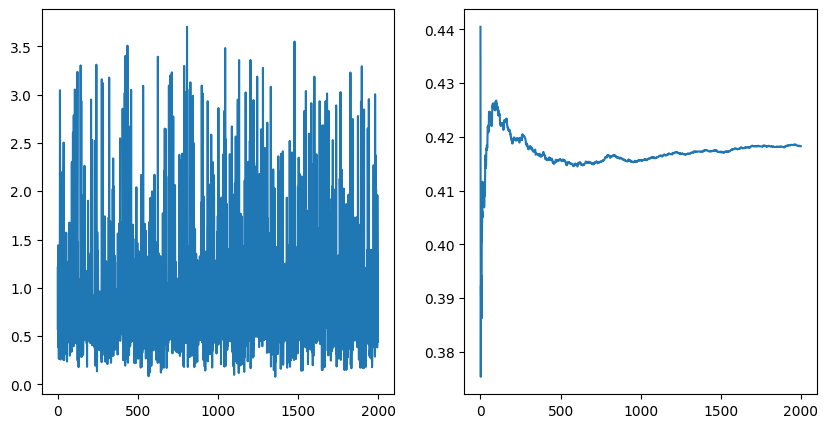

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
metrics_df = pd.DataFrame(metrics)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(metrics_df["loss"], label="loss")
plt.subplot(122) 
plt.plot(metrics_df["accuracy"], label="accuracy")

# Evaluate model

In [14]:
test_ds = tfds.load("imdb_reviews", split="test")
test_ds = (
    test_ds.map(prepare_text)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_ds_processed = test_ds.map(llm.preprocessor)
test_ds_iter = iter(test_ds)

In [15]:
for sample in test_ds_iter:
    break

parts = sample[0].numpy().decode("utf-8").split(SEPARATOR.strip())
query = parts[0] + SEPARATOR.strip()
print(query)
print(parts[1])

There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.
Sentiment:
 Positive


In [16]:
import pprint

response_text = llm.generate(query, max_length=MAX_SEQ_LENGTH)
pprint.pprint(query + response_text.numpy().decode("utf-8"))

Generating text:  24%|██▎       | 243/1024 [00:00<00:01, 396.60it/s]

('There are films that make careers. For George Romero, it was NIGHT OF THE '
 'LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add '
 "to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless "
 'film-making, and as assured and as professional as any of the aforementioned '
 "movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even "
 "then, I don't think I laughed quite this hard... So to speak.) Tukel's "
 'talent is considerable: DING-A-LING-LESS is so chock full of double '
 'entendres that one would have to sit down with a copy of this script and do '
 'a line-by-line examination of it to fully appreciate the, uh, breadth and '
 'width of it. Every shot is beautifully composed (a clear sign of a '
 "sure-handed director), and the performances all around are solid (there's "
 "none of the over-the-top scenery chewing one might've expected from a film "
 'like this). DING-A-LING-LESS is a film whose time has come.\n'
 'Senti

In [17]:
from tqdm import tqdm

y_true = []
y_pred = []
for i, sample in tqdm(enumerate(test_ds_iter)):
    parts = sample[0].numpy().decode("utf-8").split(SEPARATOR.strip())
    query = parts[0] + SEPARATOR.strip()

    response_text = llm.generate(query, max_length=MAX_SEQ_LENGTH, verbose=False)
    response_text = response_text.numpy().decode("utf-8")
    if len(response_text) > 0:
        y_true.append(parts[1])
        y_pred.append(response_text)

    if len(y_pred) >= 1000:
        break

63it [00:29,  2.14it/s]

Prompt is too long >1024 (Max Length), prompt: Favela Rising is a documentary about the slums of Rio, the favelas, specifically the most violent one, Vigário Geral. According to this film, a lot more kids have died violently in Rio's favelas over the last decade or so than in Israel/Palestine during the same period -- a fact astonishing if true, which shows how under-recognized this social problem is in the rest of the world. This is an important topic, especially for those who see hope in grassroots efforts to marshal the neediest and most at risk through a vibrant cultural program. This is a compelling documentary, if occasionally marred by a somewhat too personality-based version of events and by grainy digital video and film that sometimes may make you think you need to have your eyes examined.<br /><br />Drug lords rule in the favelas and gun-toting teenage boys are the main drug dealers, like in parts of Colombia. Fernando Meirelles' movie City of God/Cidade de Deus has been accu

136it [01:02,  2.18it/s]

Prompt is too long >1024 (Max Length), prompt: I remember the events of this movie, the ill fated cruise of Donald Crowhurst in 1968, in the Golden Globe single handed around the world yacht race. I was a 13 year old, living in England. The previous year Francis Chichester (later Sir Francis; he was knighted for his exploits) had completed the first solo circumnavigation of the globe. I remember it mostly because we were given time off school to watch his return (on a grainy black and white TV!) and then his knighting by the Queen. It provoked a huge outpouring of patriotic fervor in the UK. It all seems so quaint now. Chichester became a national hero, but he had stopped half way, in Australia, to re-fit his yacht, so the next logical step for yachtsmen was to attempt the journey without stopping.<br /><br />It's important to remember that this was a world pre-GPS, when communications on land were still pretty erratic, never mind in the middle of the ocean. Now with GPS receivers that

203it [05:17,  2.15it/s]

Prompt is too long >1024 (Max Length), prompt: I really don't think producer George Lucas didn't really set out to make such a horrible sequel as "More American Graffiti" turned out to be. But in retrospect it was the first crack in his then-seemingly impenetrable armor. Coming straight off the huge success of "American Graffiti" and produced basically at the same time as "Star Wars", this film was the first that Lucas successfully took away from Coppola without having to bother directing it himself. The result is typical Lucas -- far more interesting in terms of its structure and the way it's edited than the actual material. The writer/director Bill Norton has been allowed to use a variety of different screen ratios and split screens to produce odd associations in the images. While it's interesting to see ironic juxtapositions of the 4 story lines, the style ultimately only epitomizes the fractured nature of the film itself.<br /><br />Lucas' brilliant original film was all about a gr

271it [05:47,  2.18it/s]

Prompt is too long >1024 (Max Length), prompt: Cuore Sacro combines glossy film effects with a story that leaves much to be desired. With a script that the screen-writers for "Touched by an Angel" might have passed up as being too impuissant, Ozpetek still keeps us interested at times. In fact, I wanted to focus on the positives but I found the last act so bafflingly bizarre and awful that I think the couple who jumped to their deaths in the very beginning might have been the fortunate ones.<br /><br />This movie is at heart (pun intended) a story built on a big twist-style ending. This kind of tenuous foundation can result in a tremendous success like Tornatore's Una Pura Formalità or god-awful garbage like the films of M. Night Shyamalan. Cuore Sacro falls somewhat closer to the latter. I found the cinematography in general to be above average. The tracking shots of Irene dutifully doing her quotidian laps in the pool were very impressive as was the atmosphere conjured by the interio

447it [07:07,  2.20it/s]

Prompt is too long >1024 (Max Length), prompt: Describing this film is a difficult task. On the one hand, it's an over-the-top vampire spookfest, complete with cobwebs, eerie music, a hypnotic medallion, and of course a coffin with a creaky lid.<br /><br />On the other hand, this is one of the silliest scripts this side of Edward D. Wood, Jr. Produced by the same people who gave us "The Bloody Vampire," "Invasion of the Vampires," and this film's predecessor, the modestly-titled "The Vampire," the movie sticks close to the lack of logic that characterizes the other films.<br /><br />As I mentioned, this film is a sequel to "The Vampire," which I have not seen. But no matter...it's real easy to imagine what happened. Dr. Enrique, played by Abel "The Brainiac" Salazar, is befuddled when the well-intentioned but misguided Dr. Marion brings back the staked body of his vampiric enemy, Count Karol de Lavud (I suppose there is a rule somewhere that all vampires must be Counts of some sort). D

520it [11:05, 21.49s/it]

Prompt is too long >1024 (Max Length), prompt: This enjoyable Euro-western opens with a scene that predates a similar scene that Sergio Leone wanted to shoot for "Once Upon A Time in the West" but couldn't persuade Clint Eastwood to appear in. Three tough-looking gunfighters ride into a town. One is dressed like the Man with No Name in a poncho. Another is dressed like Colonel Mortimer from "For A Few Dollars More," and the third is garbed like Django, except he rides a horse instead of pulls a coffin behind him with a machine gun in it. Our hero meets them in Main Street behind a wagon loaded with three coffins. "Any Gun Can Play" is a spaghetti western with an in-joke on spaghetti westerns since the hero here wipes out the three killers. Aside from a little too much comedy, especially in the acrobatic fight sequences, this is an above-average oater.<br /><br />The notorious Mexican outlaw Montero (Gilbert Roland of "Barbarosa") and his gang of trigger-happy pistoleros rob an army tra

528it [11:08,  2.12s/it]

Prompt is too long >1024 (Max Length), prompt: So many people loved this movie, yet there are a few of us IMDb reviewers who found Mirrormask excruciatingly uncomfortable to watch and arse-clenchingly boring. I fall into the latter of these two camps, and I will try to explain what it was that made my toenails curl so unpleasantly.<br /><br />Firstly, to set the record straight - I like Neil Gaiman's books. I sometimes find his knowing, sarcastic, 'wry asides' humour a little geeky, and I actually prefer his work when he is playing it straight and leaving the jokes alone - but, even with his occasional lapses into crap 'dad' gags, I find his creativity and imagination to be something a bit special.<br /><br />Interestingly, one of Gaiman's strongest works is Coraline, a Gothic fairy story for kids that is very low on jokes and high on tension and creepiness. His latest novel (Anansi Boys) overdoes the funnies, and tends to read at times like Terry Pratchett does the Sisters of Mercy (n

597it [11:39,  2.23it/s]

Prompt is too long >1024 (Max Length), prompt: I would like to make it very clear that I am not at all religious. I am an atheist but I could see that Richard Dorkins was contradicting himself over and over again. I would also like to make it known that I am not the sort of person that argues against something with philosophy all the time, but I feel that when comparing science and religion we must be philosophical and be willing to question the belief in main stream science as well as questioning religious beliefs.<br /><br />I wonder if Richard Dorkins ever spends any time to think philosophically about belief, anyone who thinks long and hard enough about science and religion will realise that science is indeed a religion in itself. Yes there is a fundamental difference between the way that scientific beliefs are held when compared with other religions, but at it's roots, it's faith in a particular human instinct.<br /><br />Throughout this series, Richard insists that science method

682it [12:17,  2.17it/s]

Prompt is too long >1024 (Max Length), prompt: "Jefferson in Paris" is a truly confounding film. It presents Thomas Jefferson (Nick Nolte) in the most unflattering light possible, painting him as a liar, racist and pedophile, yet offers not a shred of condemnation for those sins. This is the way he was, the film seems to say. End of sentence, end of movie, the door's behind you.<br /><br />After arriving in Paris with his daughter Patsy (Gwenyth Paltrow), Jefferson proceeds to win the heart of Maria Cosway (Greta Scacchi), the wife of a homosexual English painter (the criminally underused Simon Callow). A turn of events sends Maria to England, however, and Jefferson proceeds to forget her with astonishing speed for a man who, mere minutes of screen time before, was asking her to live with him in America.<br /><br />He's been bewitched, you see, by Sally Hemmings (Thandie Newton), one of his slaves just arrived from America. Just why he's bewitched is hard to tell--although Sally is und

784it [13:03,  2.19it/s]

Prompt is too long >1024 (Max Length), prompt: The Polar Express. Director Robert Zemeckis, I love Back to the Future, Forrest Gump, Contact, and Who Framed Roger Rabbit (NO QUESTION MARK AFTER THAT MOVIE TITLE!!). And Tom Hanks, one of my favorite actors. The reviews of this movie were almost unanimous saying that this is an instant holiday classic. Ebert & Roeper give it two ENTHUSIASTIC thumbs up! Even Ebert's written review gave it a full four stars! Wow... OK... this I gotta see! But wait... the motion capture used looks really weird. Hmm... maybe I'm NOT so interested in seeing this anymore.<br /><br />"Well, you comin?" says the train conductor to the boy in The Polar Express. The boy is reluctant at first, and the train begins on its course without him. The boy soon changes his mind and jumps aboard just in the nick of time. <br /><br />Now, most of you have probably decided to not jump aboard this train and wait for the TV Train or Rental Express (hee hee, I'm so witty and cle

794it [13:08,  2.20it/s]

Prompt is too long >1024 (Max Length), prompt: Hearkening back to those "Good Old Days" of 1971, we can vividly recall when we were treated with a whole Season of Charles Chaplin at the Cinema. That's what the promotional guy called it when we saw him on somebody's old talk show. (We can't recall just whose it was; either MERV GRIFFIN or WOODY WOODBURY, one or the other!) The guest talked about Sir Charles' career and how his films had been out of circulation ever since the 1952 exclusion of the former "Little Tramp' from Los Estados Unidos on the grounds of his being an "undesirable Alien". (No Schultz, he's NOT from another Planet!) <br /><br />CHARLIE had been deemed to be a 'subversive' due to his interest and open inquiry into various Political and Economic Systems. Everything from the Anarchist movement from the '20s (and before), the Technocracy craze to Socialism in its various forms were fair game for discussion at Chaplin's Hollywood parties; which of course meant the inclusi

834it [13:25,  2.19it/s]

Prompt is too long >1024 (Max Length), prompt: When I typed Savage Intruder into the IMDb's search engine one of the options it came up with was Savage Garden: International Video Collection: The Story so Far (1999), the only reason I mention this is because I'm a huge Savage Garden fan & you should do yourself a favour & check some of their music out like Affirmation or To the Moon and Back rather than bother with this average pot-boiler, sorry I just wanted to say that. Anyway, Savage Intruder starts with a bizarre montage of what looks like MGM musical & premiere footage & a few spinning portraits which have no meaning whatsoever in the long run. It's late 60's Hollywood & amid the glitz & glamour a serial killer is at work selecting ageing actresses, killing them & dismembering their bodies. A young man named Vic Valance (David Garfield as John David Garfield) hops off a tour bus looking for employment when it stops at the house of a now retired actress, Katharine Parker (Miriam Ho

910it [14:00,  2.15it/s]

Prompt is too long >1024 (Max Length), prompt: Renee Zellweger is a Kansas housewife whose domineering husband is mixed up in drug trafficking. Two professional hit men -- Morgan Freeman and his son, Chris Rock, murder the husband in his dining room. Zellweger, unobserved by the killers, witnesses this and undergoes a dissociative reaction, assuming the personality of a nurse -- the eponymous Betty -- who is a character in her favorite soap opera. Believing herself to be the TV character, Zellweger takes off in her husband's car, which has a load of dope in the trunk, and travels to LA where she hopes to link up with another character in this mindless afternoon drama, "Dr. David Ravell", Greg Kinnear. Not realizing she is being pursued by the two hit men, she drives to LA where she manages to link up with Kinnear and is actually written into the show as a nurse named Betty. A handful of men in the know, including the local sheriff, catch on to what's happening and also seek Zellweger i

1000it [14:40,  2.15it/s]

Prompt is too long >1024 (Max Length), prompt: This was one of the most dishonest, meaningless, and non-peaceful of the films I have ever seen. The representation of the other, of the Israelis, was racist, backward, and unfair. For one, the song played on E.S' car radio when pulled up alongside a very right-wing Israeli driver was "I put a spell on you" by Natacha Atlas. The song's style is quite Arabic, but it was released on an Israeli compilation CD, and I have even heard it on the radio in Israel. Many Israeli songs (as well as architecture, foods, and slang) are influenced by Arabic culture, and there is no reason an Israeli Jew would be offended or angered by a nearby car playing that song. The way E.S. appears so calm and collected with his sunglasses and cool glare, via a long, still shot, is meant to force the viewer into seeing the Jew as haggard and racist, and E.S. as noble and temperate.<br /><br />I have traveled all over Israel, and I have never seen an IDF recruitment p

1013it [14:46,  1.14it/s]


In [18]:
import numpy as np
(np.array(y_true) == np.array(y_pred)).mean()

0.942

In [24]:
(np.array(["Positive" in y for y in y_true]) == np.array(["Positive" in y for y in y_pred])).mean()

0.944